# Notebook to merge the VegFru dataset with Nutrify

* **Goal:** Merge the relevant classes + images from the VegFru dataset on Kaggle (https://www.kaggle.com/datasets/zhaoyj688/vegfru) to the Nutrify database.

* See this Google Sheet for classes relevant to Nutrify: https://docs.google.com/spreadsheets/d/1AbDDAuntzaI140wf5nAAgTbXe8thKJLr5E2ZbTlurbg/edit#gid=0 


In [9]:
# Append the upper level directory to sys
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

from pathlib import Path

import torch

from tqdm.auto import tqdm

from utils.misc import sort_dict_by_values

from zero_shot_classification import open_clip_compute_image_features_of_list, open_clip_compute_text_features, open_clip_zero_shot_classification, open_clip_get_image_and_text_similarity_dicts

In [10]:
# Get original labels to label new data from
# Get config
from configs.default_config import config

args = config

# Connect to GCP
from utils.gcp_utils import set_gcp_credentials, test_gcp_connection
set_gcp_credentials(path_to_key="../utils/google-storage-key.json")
test_gcp_connection()

import wandb

# Initialize a new run
from utils.wandb_utils import wandb_load_artifact, wandb_download_and_load_labels

notes = f"merge vegfru dataset with Nutrify"

run = wandb.init(project=args.wandb_project, 
                 job_type=args.wandb_job_type,
                 tags=['auto_label_new_images'],
                 notes=notes)

annotations, class_names, class_dict, reverse_class_dict, labels_path = wandb_download_and_load_labels(wandb_run=run,
wandb_labels_artifact_name=args.wandb_labels_artifact)

len(annotations.label.unique())

[INFO] GCP credentials set!
[INFO] GCP connection successful! Access to GCP for saving/loading data and models available.


[INFO] Labels directory: ./artifacts/food_vision_labels:v42
[INFO] Labels path: artifacts/food_vision_labels:v42/annotations.csv
[INFO] Working with: 252 classes


252

In [11]:
class_dict

{0: 'almond_butter',
 1: 'almonds',
 2: 'apple_green',
 3: 'apple_red',
 4: 'apricot',
 5: 'artichoke',
 6: 'asparagus',
 7: 'avocado',
 8: 'bacon',
 9: 'bacon_and_egg_burger',
 10: 'bagel',
 11: 'baklava',
 12: 'banana',
 13: 'banana_bread',
 14: 'barbecue_sauce',
 15: 'basil',
 16: 'bean_sprouts',
 17: 'beans',
 18: 'beef_curry',
 19: 'beef_diced',
 20: 'beef_kebab',
 21: 'beef_mince',
 22: 'beef_patty',
 23: 'beef_roast',
 24: 'beef_stir_fry',
 25: 'beer',
 26: 'beetroot',
 27: 'biltong',
 28: 'blackberries',
 29: 'blueberries',
 30: 'bok_choy',
 31: 'bread',
 32: 'bread_naan',
 33: 'broccoli',
 34: 'broccolini',
 35: 'brownie',
 36: 'brussel_sprouts',
 37: 'burrito',
 38: 'butter',
 39: 'cabbage_green',
 40: 'cabbage_red',
 41: 'calamari',
 42: 'candy',
 43: 'capsicum_green',
 44: 'capsicum_orange',
 45: 'capsicum_red',
 46: 'capsicum_yellow',
 47: 'carrot',
 48: 'cashews',
 49: 'cauliflower',
 50: 'celery',
 51: 'cheese',
 52: 'cheeseburger',
 53: 'cherries',
 54: 'chicken_breast'

## Import VegFru class names

Source: https://docs.google.com/spreadsheets/d/1AbDDAuntzaI140wf5nAAgTbXe8thKJLr5E2ZbTlurbg/edit#gid=0

In [4]:
vegfru = pd.read_csv("nutrify-vegfru-dataset-class-crossover.csv")
print(f"Num rows: {len(vegfru)}")
vegfru.head()

Num rows: 293


class_name  in_nutrify nutrify_class_name category notes  \
0           almond         1.0            almonds    fruit   NaN   
1      green_apple         1.0        apple_green    fruit   NaN   
2            apple         1.0          apple_red    fruit   NaN   
3          apricot         1.0            apricot    fruit   NaN   
4  globe_artichoke         1.0          artichoke    fruit   NaN   

   Link to vegfru dataset -- https://www.kaggle.com/datasets/zhaoyj688/vegfru   
0                                                NaN                            
1                                                NaN                            
2                                                NaN                            
3                                                NaN                            
4                                                NaN

In [5]:
# Drop rows if the nutrify_class_name is nan
vegfru = vegfru.dropna(subset=['nutrify_class_name'])
print(f"Num rows: {len(vegfru)}")

Num rows: 107


In [6]:
# Get the unique class names
vegfru_nutrify_unique_class_names = vegfru.nutrify_class_name.unique()

# Compare the unique class names to the class names in the annotations
# nutrify_class_names_not_in_vegfru = [class_name for class_name in annotations.label.unique() if class_name not in vegfru_nutrify_unique_class_names]
# nutrify_class_names_in_vegfru = [class_name for class_name in annotations.label.unique() if class_name in vegfru_nutrify_unique_class_names]
vegfru_class_names_not_in_nutrify = sorted([class_name for class_name in vegfru_nutrify_unique_class_names if class_name not in class_names])
vegfru_class_names_not_in_nutrify

['artichoke',
 'bean_sprouts',
 'cherry_tomato',
 'chicory',
 'choko',
 'choy_sum',
 'cos_lettuce',
 'enoki_mushroom',
 'iceberg_lettuce',
 'mangosteen',
 'sweet_potato']

In [7]:
filter_list = ["cherry_tomato", "iceberg_lettuce", "sweet_potato", "enoki_mushroom", "cos_lettuce"]

# Remove the classes in the filter list
vegfru_class_names_not_in_nutrify = [class_name for class_name in vegfru_class_names_not_in_nutrify if class_name not in filter_list]
vegfru_class_names_not_in_nutrify

['artichoke', 'bean_sprouts', 'chicory', 'choko', 'choy_sum', 'mangosteen']

In [8]:
# How many images are in all_vegfru_images
target_dir = 'all_vegfru_images'
path = Path(target_dir)
image_paths = sorted(list(path.glob('*/*.jp*g')))
print(f"There are {len(image_paths)} images in {target_dir}")

There are 160731 images in all_vegfru_images


In [9]:
vegfru_class_names_to_move_to_nutrify = vegfru.class_name.to_list()
vegfru_nutrify_unique_class_names  = vegfru.nutrify_class_name.to_list()
len(vegfru_class_names_to_move_to_nutrify), len(vegfru_nutrify_unique_class_names)

(107, 107)

In [10]:
# Get rows of vegfru where the nutrify_class_name is in vegfru_class_names_not_in_nutrify
vegfru_class_names_not_in_nutrify_df = vegfru[vegfru.nutrify_class_name.isin(vegfru_class_names_not_in_nutrify)]
vegfru_class_names_not_in_nutrify_df

class_name  in_nutrify nutrify_class_name   category notes  \
4          globe_artichoke         1.0          artichoke      fruit   NaN   
9       black_bean_sprouts         1.0       bean_sprouts  vegetable   NaN   
10       mung_bean_sprouts         1.0       bean_sprouts  vegetable   NaN   
11         soybean_sprouts         1.0       bean_sprouts        NaN   NaN   
24                 chicory         1.0            chicory  vegetable   NaN   
27                  chocho         1.0              choko      fruit   NaN   
28  flower_chinese_cabbage         1.0           choy_sum  vegetable   NaN   
63              mangosteen         1.0         mangosteen      fruit   NaN   

    Link to vegfru dataset -- https://www.kaggle.com/datasets/zhaoyj688/vegfru   
4                                                 NaN                            
9                                                 NaN                            
10                                                NaN                            
11                                                NaN                            
24                                                NaN                            
27                                                NaN                            
28                                                NaN                            
63                                                NaN

In [11]:
vegfru_class_names_to_move_to_nutrify = vegfru_class_names_not_in_nutrify_df.class_name.to_list()
vegfru_class_names_to_move_to_nutrify

['globe_artichoke',
 'black_bean_sprouts',
 'mung_bean_sprouts',
 'soybean_sprouts',
 'chicory',
 'chocho',
 'flower_chinese_cabbage',
 'mangosteen']

In [12]:
# How many images are in the folders of the vegfru_class_names_to_move_to_nutrify
vegfru_nutrify_images = []
for image_path in image_paths:
    if image_path.parent.name in vegfru_class_names_to_move_to_nutrify:
        vegfru_nutrify_images.append(image_path)
print(f"There are {len(vegfru_nutrify_images)} images in {target_dir} that are in the vegfru_class_names_to_move_to_nutrify")

There are 3840 images in all_vegfru_images that are in the vegfru_class_names_to_move_to_nutrify


In [13]:
# Get a map of the vegfru class names to the nutrify class names
vegfru_to_nutrify_dict = vegfru[["class_name", "nutrify_class_name"]].drop_duplicates().set_index("class_name").to_dict()["nutrify_class_name"]
len(vegfru_to_nutrify_dict)

107

In [34]:
# Get the subset of vegfru_class_names_to_move_to_nutrify from vegfru_to_nutrify_dict
# vegfru_to_nutrify_dict = {key: value for key, value in vegfru_to_nutrify_dict.items() if key in vegfru_class_names_to_move_to_nutrify}
vegfru_classes_to_move_to_nutrify_dict = {key: value for key, value in vegfru_to_nutrify_dict.items() if key in vegfru_class_names_to_move_to_nutrify}
vegfru_classes_to_move_to_nutrify_list = list(set(vegfru_classes_to_move_to_nutrify_dict.values()))
vegfru_classes_to_move_to_nutrify_list

['bean_sprouts', 'artichoke', 'choy_sum', 'choko', 'chicory', 'mangosteen']

In [35]:
# Make a directory for storing nutrify-vegfru images
# !mkdir all_nutrify_vegfru

# Make a directory for each class inside all_nutrify_vegfru
import os
nutrify_vegfru_dir = "all_nutrify_vegfru"
for class_name in vegfru_to_nutrify_dict.values():
    os.makedirs(f"{nutrify_vegfru_dir}/{class_name}", exist_ok=True)
    # !mkdir all_nutrify_vegfru/{class_name}

In [53]:
# Copy the images to the correct directory
import shutil
from tqdm.auto import tqdm
for i, image_path in tqdm(enumerate(vegfru_nutrify_images)):
    if image_path.parent.name in vegfru_class_names_to_move_to_nutrify:

        # Get the nutrify class name
        nutrify_class_name = vegfru_to_nutrify_dict[image_path.parent.name]
        # Copy the image to the nutrify class name directory
        targ_file = f"{nutrify_vegfru_dir}/{nutrify_class_name}/{image_path.name}"
        if not os.path.exists(targ_file):
            # if i % 100 == 0:
                # print(f"Copying {image_path} to {nutrify_vegfru_dir}/{nutrify_class_name}/{image_path.name}")
            shutil.copy(image_path, f"{nutrify_vegfru_dir}/{nutrify_class_name}/{image_path.name}")
        else:
            print(f"File already exists: {targ_file}")

0it [00:00, ?it/s]

File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0001.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0002.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0005.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0006.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0007.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0008.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0009.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0011.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0012.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0013.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0014.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0015.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0016.jpg
File already exists: all_nutrify_vegfru/bean_sprouts/v_04_01_0017.jpg
File already exists:

In [54]:
# Get all the paths
nutrify_vegfru_paths = sorted(list(Path(nutrify_vegfru_dir).glob('*/*.jp*g')))
print(len(nutrify_vegfru_paths))

import uuid

def is_valid_uuid(string):
    try:
        uuid.UUID(string)
        return True
    except ValueError:
        return False

# Loop through all_paths, if the path is a UUID, pass, if not, rename the file to a UUID
for path in tqdm(nutrify_vegfru_paths):
    if not is_valid_uuid(path.stem):
        print(f"[INFO] {path} isn't valud UUID, renaming to UUID...")
        new_name = f"{uuid.uuid4()}.jpeg"
        new_path_name = path.parent / new_name
        path.rename(new_path_name)
        print(f"[INFO] Renamed {path} to {new_path_name}")

# Get all the paths again
nutrify_vegfru_paths = sorted(list(Path(nutrify_vegfru_dir).glob('*/*.jp*g')))

# Remove corrupted images
from PIL import Image

num_corrupted_images = 0
for path in nutrify_vegfru_paths:
    try:
        with Image.open(path) as img:
            img.verify()
            img.close()
    except:
        print(f"[INFO] {path} is corrupted, removing...")
        os.remove(path)
        num_corrupted_images += 1

# Get all the paths again
nutrify_vegfru_paths = sorted(list(Path(nutrify_vegfru_dir).glob('*/*.jp*g')))

6821


  0%|          | 0/6821 [00:00<?, ?it/s]

[INFO] all_nutrify_vegfru/artichoke/v_12_05_0001.jpg isn't valud UUID, renaming to UUID...
[INFO] Renamed all_nutrify_vegfru/artichoke/v_12_05_0001.jpg to all_nutrify_vegfru/artichoke/c742f8dd-ecb6-4b5b-bd4e-1cd201422a02.jpeg
[INFO] all_nutrify_vegfru/artichoke/v_12_05_0002.jpg isn't valud UUID, renaming to UUID...
[INFO] Renamed all_nutrify_vegfru/artichoke/v_12_05_0002.jpg to all_nutrify_vegfru/artichoke/b7e36e1f-2ef7-4f3f-ac89-f2ff633191d1.jpeg
[INFO] all_nutrify_vegfru/artichoke/v_12_05_0003.jpg isn't valud UUID, renaming to UUID...
[INFO] Renamed all_nutrify_vegfru/artichoke/v_12_05_0003.jpg to all_nutrify_vegfru/artichoke/b28637a2-3543-47dd-9eee-c424f92baf7a.jpeg
[INFO] all_nutrify_vegfru/artichoke/v_12_05_0004.jpg isn't valud UUID, renaming to UUID...
[INFO] Renamed all_nutrify_vegfru/artichoke/v_12_05_0004.jpg to all_nutrify_vegfru/artichoke/f51a66b4-72ca-43e5-98bf-3d467697666d.jpeg
[INFO] all_nutrify_vegfru/artichoke/v_12_05_0005.jpg isn't valud UUID, renaming to UUID...
[INFO

There are 3839 images in all_nutrify_vegfru that are in the classes_to_filter_nutrify_names


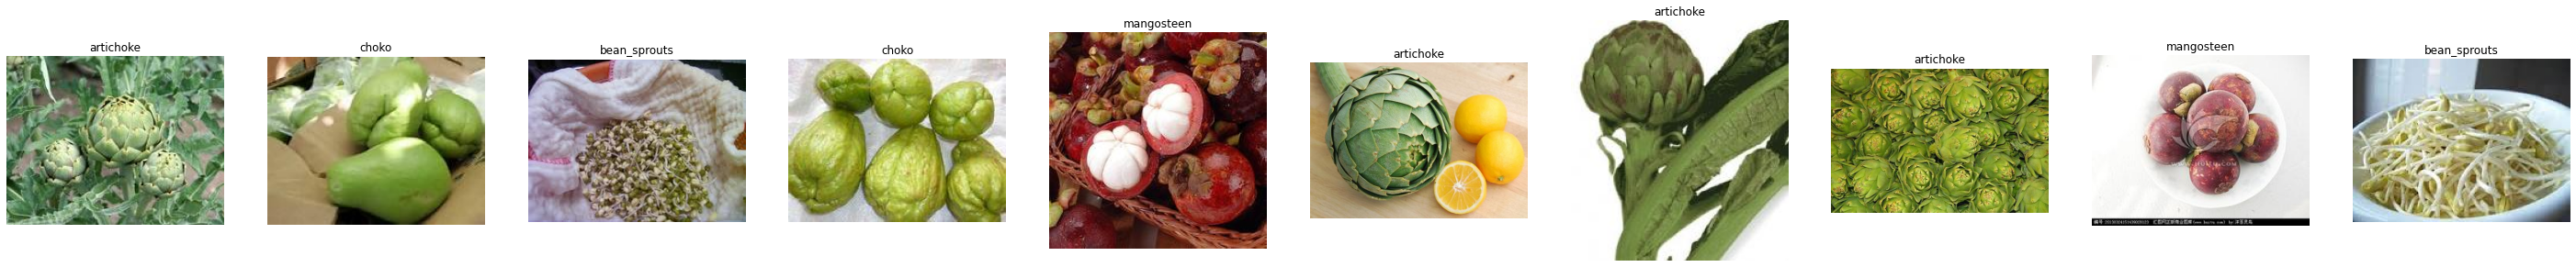

In [55]:
# Show some random images from the dataset
import random
import matplotlib.pyplot as plt

# Get image_paths for the classes we want to filter
image_paths_to_filter = []
for image_path in nutrify_vegfru_paths:
    if image_path.parent.name in vegfru_class_names_not_in_nutrify:
        image_paths_to_filter.append(image_path)

print(f"There are {len(image_paths_to_filter)} images in {nutrify_vegfru_dir} that are in the classes_to_filter_nutrify_names")

def show_random_images(image_paths, num_images=10):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images*5, 5))
    for i in range(num_images):
        image_path = random.choice(image_paths)
        image = plt.imread(image_path)
        ax[i].imshow(image)
        ax[i].set_title(image_path.parent.name)
        ax[i].axis("off")
    plt.show()

show_random_images(image_paths_to_filter, num_images=10)

## See whether the images contain people or not 

* Use CLIP to decide whether the image has a person or not (we're only interested in images without people)

In [56]:
images_to_move_to_nutrify_features = open_clip_compute_image_features_of_list(image_paths_to_filter)

Computing OpenCLIP image features:   0%|          | 0/3839 [00:00<?, ?it/s]

In [57]:
human_or_not = ["human", "no_human", "food", "other", "human_face", "person"]

human_or_not_similarity_dicts = open_clip_get_image_and_text_similarity_dicts(images_to_move_to_nutrify_features, human_or_not)

Calculating image features and similarity dicts:   0%|          | 0/3839 [00:00<?, ?it/s]

In [58]:
human_or_not_df = pd.DataFrame(human_or_not_similarity_dicts)

human_or_not_df.open_clip_top_1_class_name.value_counts()

food          3706
other          101
human           14
person          11
no_human         4
human_face       3
Name: open_clip_top_1_class_name, dtype: int64

In [59]:
# Get the image paths which don't contain a person
food_only = human_or_not_df[human_or_not_df.open_clip_top_1_class_name == "food"]
may_contain_person = human_or_not_df[human_or_not_df.open_clip_top_1_class_name != "food"]

no_person_image_paths = food_only.image_path.to_list()
len(no_person_image_paths)

3706

In [60]:
# Delete images which aren't food
images_removed = 0
for image_path in tqdm(may_contain_person.image_path.to_list()):
    print(f"Deleting {image_path}")
    images_removed += 1
    os.remove(image_path)

  0%|          | 0/133 [00:00<?, ?it/s]

Deleting all_nutrify_vegfru/artichoke/00060174-5920-42c2-8908-4061324d91b8.jpeg
Deleting all_nutrify_vegfru/artichoke/389d6107-7058-45b8-9be8-79480eedab28.jpeg
Deleting all_nutrify_vegfru/artichoke/616f1b66-6ab4-40df-b562-3a31c9d1d1ea.jpeg
Deleting all_nutrify_vegfru/artichoke/a0d2a7ee-fcea-4074-8e6f-682ade7de58b.jpeg
Deleting all_nutrify_vegfru/artichoke/a7c2745d-354d-4312-8c00-00b10ff2c427.jpeg
Deleting all_nutrify_vegfru/artichoke/d124a4a2-43a4-4f68-8cd2-c6e5be6db7aa.jpeg
Deleting all_nutrify_vegfru/bean_sprouts/006d8746-11dd-4fac-a090-c32a38125902.jpeg
Deleting all_nutrify_vegfru/bean_sprouts/08eb761c-a2b1-4899-bdcd-0fb2c5a8a1ac.jpeg
Deleting all_nutrify_vegfru/bean_sprouts/09271833-7577-46d7-88fd-32487801689c.jpeg
Deleting all_nutrify_vegfru/bean_sprouts/0aef921f-76cb-48ab-b74b-55af79e3b697.jpeg
Deleting all_nutrify_vegfru/bean_sprouts/0b8f7ca9-2c9a-42fe-9aa1-15e61c13fee1.jpeg
Deleting all_nutrify_vegfru/bean_sprouts/0bda21d4-0459-4253-acf5-190d5efea939.jpeg
Deleting all_nutrify_v

In [61]:
# Get all the paths to the images in nutrify_vegfru_dir
print(nutrify_vegfru_dir)
updated_image_paths = list(Path(nutrify_vegfru_dir).rglob("*/*.jp*g"))
len(updated_image_paths)

all_nutrify_vegfru


6687

In [62]:
# Make sure only image paths are in vegfru_class_names_to_move_to_nutrify
updated_image_paths = [image_path for image_path in updated_image_paths if image_path.parent.name in vegfru_classes_to_move_to_nutrify_list]
print(len(updated_image_paths))

3706


In [63]:
class_dict_updated = class_dict.copy()
class_names_updated = class_names.copy()
reverse_class_dict_updated = reverse_class_dict.copy()

print(f"Number of classes in Nutrify: {len(class_names)}")

Number of classes in Nutrify: 247


In [64]:
# Add new classes to class_dict
for food_type in vegfru_classes_to_move_to_nutrify_list:
    class_dict_updated[len(class_dict_updated)] = food_type
    class_names_updated.append(food_type)
    reverse_class_dict_updated[food_type] = len(class_dict_updated)-1

In [65]:
print(f"Number of classes in Nutrify: {len(class_names_updated)}")
print(f"New classes: {vegfru_classes_to_move_to_nutrify_list}")

Number of classes in Nutrify: 253
New classes: ['bean_sprouts', 'artichoke', 'choy_sum', 'choko', 'chicory', 'mangosteen']


In [66]:
assert len(class_names_updated) == len(set(class_names_updated))

In [67]:
from utils.misc import get_now_time

# Create a list of dictionaries and fill out the columns of the annotations
columns = config.annotations_columns_to_export

food_image_dict_list = []

image_source = "vegfru_dataset"
label_source = "vegfru_dataset_with_manual_filtering"
label_last_updated_at = get_now_time()

for image_path in updated_image_paths:
    food_image_dict = {}
    food_image_dict['filename'] = image_path
    food_image_dict['image_name'] = image_path.name
    food_image_dict['class_name'] = image_path.parent.name
    food_image_dict['label'] = reverse_class_dict_updated[image_path.parent.name]
    # food_image_dict['split'] = 'train'
    # Label 20% of the images as test
    if np.random.random() < 0.2:
        food_image_dict['split'] = 'test'
    else:
        food_image_dict['split'] = 'train'
    food_image_dict['clear_or_confusing'] = None
    food_image_dict['whole_food_or_dish'] = None
    food_image_dict['one_food_or_multiple'] = None
    food_image_dict['label_last_updated_at'] = label_last_updated_at
    food_image_dict['label_source'] = label_source
    food_image_dict['image_source'] = image_source

    food_image_dict_list.append(food_image_dict)

# Create a dataframe from the list of dictionaries
import pandas as pd
new_annotations = pd.DataFrame(food_image_dict_list)
new_annotations.head()

filename  \
0  all_nutrify_vegfru/mangosteen/ce3ca676-95aa-4a...   
1  all_nutrify_vegfru/mangosteen/0a3f274a-4199-42...   
2  all_nutrify_vegfru/mangosteen/0cc6a038-0404-4f...   
3  all_nutrify_vegfru/mangosteen/289d590e-b853-4c...   
4  all_nutrify_vegfru/mangosteen/95511cdb-e830-44...   

                                  image_name  class_name  label  split  \
0  ce3ca676-95aa-4a47-aaf8-3e9cbd27df29.jpeg  mangosteen    252  train   
1  0a3f274a-4199-423b-ba8f-ffa6fd9784ca.jpeg  mangosteen    252  train   
2  0cc6a038-0404-4f2f-a95a-4e562161514b.jpeg  mangosteen    252   test   
3  289d590e-b853-4c57-8090-f82426b3c48c.jpeg  mangosteen    252  train   
4  95511cdb-e830-44cb-84fb-b991c5dfbbea.jpeg  mangosteen    252  train   

  clear_or_confusing whole_food_or_dish one_food_or_multiple  \
0               None               None                 None   
1               None               None                 None   
2               None               None                 None   
3               None               None                 None   
4               None               None                 None   

  label_last_updated_at                          label_source    image_source  
0   2023-03-06_17-21-11  vegfru_dataset_with_manual_filtering  vegfru_dataset  
1   2023-03-06_17-21-11  vegfru_dataset_with_manual_filtering  vegfru_dataset  
2   2023-03-06_17-21-11  vegfru_dataset_with_manual_filtering  vegfru_dataset  
3   2023-03-06_17-21-11  vegfru_dataset_with_manual_filtering  vegfru_dataset  
4   2023-03-06_17-21-11  vegfru_dataset_with_manual_filtering  vegfru_dataset

In [68]:
# Get the split of the new annotations
new_annotations.split.value_counts()

train    2946
test      760
Name: split, dtype: int64

In [69]:
# Get the number of images in each class
new_annotations.class_name.value_counts()

bean_sprouts    1015
mangosteen      1011
artichoke        936
choko            438
chicory          306
Name: class_name, dtype: int64

In [70]:
# Get the rows with labels over 208
new_annotations[new_annotations.label > 208].class_name.value_counts()

bean_sprouts    1015
mangosteen      1011
artichoke        936
choko            438
chicory          306
Name: class_name, dtype: int64

In [71]:
original_annotations = annotations.copy()

In [72]:
len(original_annotations), len(new_annotations)

(111176, 3706)

In [73]:
# Append the new_annotations to the original_annotations
updated_annotations = pd.concat([original_annotations, new_annotations], ignore_index=True)

# updated_annotations = original_annotations.(new_annotations, ignore_index=True)
len(updated_annotations)

114882

In [79]:
from typing import List, Dict, Tuple

def get_updated_class_names_class_dict_and_reverse_class_dict(df: pd.DataFrame) -> Tuple[List[str], Dict[int, str], Dict[str, int]]:
    """Get an updated class names list, class dict and reverse class dict from a dataframe."""
    updated_class_names = sorted(df.class_name.unique())
    updated_class_dict = {i: class_name for i, class_name in enumerate(updated_class_names)}
    updated_reverse_class_dict = {class_name: i for i, class_name in enumerate(updated_class_names)}
    assert len(updated_class_dict) == len(updated_reverse_class_dict), "Class dict and reverse class dict are not the same length"
    return updated_class_names, updated_class_dict, updated_reverse_class_dict

def map_updated_class_dict_to_updated_annotations(df: pd.DataFrame, updated_reverse_class_dict: Dict[str, int]) -> pd.DataFrame:
    """Map updated class dict to updated annotations dataframe.
    
    For example, go from {"apple_red": 1} -> df["label"] = 1
    """
    updated_annotations = df.copy()
    updated_annotations.loc[:, 'label'] = updated_annotations['class_name'].map(updated_reverse_class_dict)
    assert len(updated_annotations.label.unique()) == len(updated_reverse_class_dict), "Number of unique labels in updated annotations does not match number of unique class names in updated reverse class dict"
    return updated_annotations

In [80]:
updated_class_names, updated_class_dict, updated_reverse_class_dict = get_updated_class_names_class_dict_and_reverse_class_dict(updated_annotations)

updated_annotations = map_updated_class_dict_to_updated_annotations(updated_annotations, updated_reverse_class_dict)

len(updated_class_names), updated_class_names[:10]

(252,
 ['almond_butter',
  'almonds',
  'apple_green',
  'apple_red',
  'apricot',
  'artichoke',
  'asparagus',
  'avocado',
  'bacon',
  'bacon_and_egg_burger'])

In [82]:
updated_class_dict

{0: 'almond_butter',
 1: 'almonds',
 2: 'apple_green',
 3: 'apple_red',
 4: 'apricot',
 5: 'artichoke',
 6: 'asparagus',
 7: 'avocado',
 8: 'bacon',
 9: 'bacon_and_egg_burger',
 10: 'bagel',
 11: 'baklava',
 12: 'banana',
 13: 'banana_bread',
 14: 'barbecue_sauce',
 15: 'basil',
 16: 'bean_sprouts',
 17: 'beans',
 18: 'beef_curry',
 19: 'beef_diced',
 20: 'beef_kebab',
 21: 'beef_mince',
 22: 'beef_patty',
 23: 'beef_roast',
 24: 'beef_stir_fry',
 25: 'beer',
 26: 'beetroot',
 27: 'biltong',
 28: 'blackberries',
 29: 'blueberries',
 30: 'bok_choy',
 31: 'bread',
 32: 'bread_naan',
 33: 'broccoli',
 34: 'broccolini',
 35: 'brownie',
 36: 'brussel_sprouts',
 37: 'burrito',
 38: 'butter',
 39: 'cabbage_green',
 40: 'cabbage_red',
 41: 'calamari',
 42: 'candy',
 43: 'capsicum_green',
 44: 'capsicum_orange',
 45: 'capsicum_red',
 46: 'capsicum_yellow',
 47: 'carrot',
 48: 'cashews',
 49: 'cauliflower',
 50: 'celery',
 51: 'cheese',
 52: 'cheeseburger',
 53: 'cherries',
 54: 'chicken_breast'

In [83]:
# How many unique class_names are in original_annotations?
len(original_annotations['class_name'].unique())

247

In [84]:
# How many unique class_names are in updated_annotations?
len(updated_annotations['class_name'].unique())

252

In [85]:
# Check the difference in lengths between the original_annotations and updated_annotations
num_differences = len(updated_annotations) - len(original_annotations)
print(num_differences)

3706


In [88]:
updated_annotations.columns == original_annotations.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [89]:
# from utils.misc import check_for_differences_between_df

# num_differences = check_for_differences_between_df(updated_annotations, original_annotations)
# num_differences

In [90]:
# Upload the updated annotations to Google Storage and track the changes
from utils.gcp_utils import upload_to_gs, rename_blob, delete_blob
from utils.wandb_utils import wandb_add_artifact_with_reference
from utils.misc import get_now_time
import os

GS_BUCKET_NAME = config.gs_bucket_name

UPDATED_ANNOTATIONS_TARGET_FILENAME = "updated_annotations.csv"
ORIGINAL_ANNOTATIONS_TARGET_FILENAME = "annotations.csv"

# Export the updated annotations to a CSV
columns_to_export = config.annotations_columns_to_export
print(f"[INFO] Exporting the following columns to {UPDATED_ANNOTATIONS_TARGET_FILENAME}: {columns_to_export}")

# TODO: Check if the updated_annotations_reset_index and the original_annotations actually differ, if so save them and upload them, else exit
if num_differences > 0:
    print(f"[INFO] {num_differences} changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv")

    # Export the updated_annotations_reset_index to a csv
    updated_annotations[columns_to_export].to_csv(UPDATED_ANNOTATIONS_TARGET_FILENAME, index=False)

    # Upload the updated CSV to Google Storage
    upload_to_gs(bucket_name=GS_BUCKET_NAME, 
                 source_file_name=UPDATED_ANNOTATIONS_TARGET_FILENAME, 
                 destination_blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME)

    # Rename the old CSV on Google Storage
    bucket_to_move_old_annotations_to = "old_annotations"
    name_to_rename_old_annotations = os.path.join(bucket_to_move_old_annotations_to, f"{get_now_time()}_old_annotations.csv")

    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME,
                new_name=name_to_rename_old_annotations)

    # Rename the "updated_annotations.csv" on Google Storage to "annotations.csv" 
    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME,
                new_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME)

    # Track the changes in the annotations with Weights & Biases
    annotations_path_on_gcs = f"gs://{GS_BUCKET_NAME}/{ORIGINAL_ANNOTATIONS_TARGET_FILENAME}"
    wandb_add_artifact_with_reference(wandb_run=run,
                                      artifact_name="food_vision_labels",
                                      artifact_type="labels",
                                      description="Labels for FoodVision project",
                                      reference_path=annotations_path_on_gcs)
else:
    print("[INFO] No changes to annotations.csv, updated label files and original annotations are the same, try fixing/updating the label files and try again")

[INFO] Exporting the following columns to updated_annotations.csv: ['filename', 'image_name', 'class_name', 'label', 'split', 'clear_or_confusing', 'whole_food_or_dish', 'one_food_or_multiple', 'label_last_updated_at', 'label_source', 'image_source']
[INFO] 3706 changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv
[INFO] Uploading updated_annotations.csv to updated_annotations.csv...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File updated_annotations.csv uploaded to food_vision_bucket_with_object_versioning/updated_annotations.csv.
[INFO] File size: 22117993 bytes
[INFO] Blob annotations.csv has been renamed to old_annotations/2023-03-06_17-25-30_old_annotations.csv
[INFO] Blob updated_annotations.csv has been renamed to annotations.csv
[INFO] Logging 'food_vision_labels' from 'gs://food_vision_bucket_with_object_versioning/annotations.csv' to Weights & Biases...


## Upload all photos to Google Storage

In [91]:
from utils.gcp_utils import upload_to_gs, get_list_of_blobs

# Get list of images already in GCP bucket
gs_image_paths = get_list_of_blobs(bucket_name=GS_BUCKET_NAME, prefix="all_images")
print(f"[INFO] There are {len(gs_image_paths)} images in the GCP bucket")

[INFO] There are 110309 images in the GCP bucket


In [97]:
target_upload_dir = "all_nutrify_vegfru"
print(target_upload_dir)

all_nutrify_vegfru


In [98]:
# Upload the images to Google Storage
!gsutil -m cp -r "$target_upload_dir/*/*.jp*g" gs://$GS_BUCKET_NAME/all_images/

Copying file://all_nutrify_vegfru/mangosteen/ce3ca676-95aa-4a47-aaf8-3e9cbd27df29.jpeg [Content-Type=image/jpeg]...
Copying file://all_nutrify_vegfru/mangosteen/0a3f274a-4199-423b-ba8f-ffa6fd9784ca.jpeg [Content-Type=image/jpeg]...
Copying file://all_nutrify_vegfru/mangosteen/0cc6a038-0404-4f2f-a95a-4e562161514b.jpeg [Content-Type=image/jpeg]...
Copying file://all_nutrify_vegfru/mangosteen/289d590e-b853-4c57-8090-f82426b3c48c.jpeg [Content-Type=image/jpeg]...
Copying file://all_nutrify_vegfru/mangosteen/95511cdb-e830-44cb-84fb-b991c5dfbbea.jpeg [Content-Type=image/jpeg]...
Copying file://all_nutrify_vegfru/mangosteen/94fe853e-ea15-4476-a5b5-eff9a1088e58.jpeg [Content-Type=image/jpeg]...
Copying file://all_nutrify_vegfru/mangosteen/e7ee6e84-7a65-46e8-82b0-e4b9f3f478b4.jpeg [Content-Type=image/jpeg]...
Copying file://all_nutrify_vegfru/mangosteen/32dfbbbd-a174-4680-add0-26e730ed9939.jpeg [Content-Type=image/jpeg]...
Copying file://all_nutrify_vegfru/mangosteen/3b6a47f0-8341-4b52-93e0-7d9

In [5]:
GS_BUCKET_NAME = config.gs_bucket_name
GS_BUCKET_NAME

'food_vision_bucket_with_object_versioning'

In [6]:
!gsutil -m mv gs://$GS_BUCKET_NAME/all_images/*/* gs://$GS_BUCKET_NAME/all_images/

Copying gs://food_vision_bucket_with_object_versioning/all_images/angosteen/00128bad-7280-4952-8db1-172679efb99e.jpeg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/angosteen/003561e8-cb5b-4058-b38e-09e560469b80.jpeg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/angosteen/0035c32b-fccb-4c00-9b92-9d882210c1de.jpeg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/angosteen/00eab501-1605-490c-b33d-987360e30c7b.jpeg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/angosteen/00f7351a-9cef-4a9c-b4aa-070dda34b3dd.jpeg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/angosteen/00f74664-dfb2-4a7d-bbd6-518c9f39c669.jpeg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/angosteen/011d5ad9-7791-4b01-b9a4-230379e62d10.jpeg 

In [7]:
from utils.gcp_utils import upload_to_gs, get_list_of_blobs

# Get list of images already in GCP bucket
gs_image_paths = get_list_of_blobs(bucket_name=GS_BUCKET_NAME, prefix="all_images")
print(f"[INFO] There are {len(gs_image_paths)} images in the GCP bucket")

[INFO] There are 117574 images in the GCP bucket


In [8]:
# Track the changes to GCP bucket with Weights & Biases
from utils.wandb_utils import wandb_add_artifact_with_reference

# Track updated images_dir in Weights & Biases
food_images_path_on_gs = "gs://food_vision_bucket_with_object_versioning/all_images"

wandb_add_artifact_with_reference(wandb_run=run,
                                  artifact_name="food_vision_199_classes_images",
                                  artifact_type="dataset",
                                  description="Images for FoodVision project",
                                  reference_path=food_images_path_on_gs)

[INFO] Logging 'food_vision_199_classes_images' from 'gs://food_vision_bucket_with_object_versioning/all_images' to Weights & Biases...


wandb: Generating checksum for up to 1000000000 objects with prefix "all_images"... Done. 23.5s
